<a href="https://colab.research.google.com/github/detauportuno/Projeto_Pinturas_PAE/blob/main/EstilosImagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução à inteligência artificial

## Transferência de estilo com redes neurais profundas


Nesta aula, recriaremos um método de transferência de estilo descrito no artigo [Transferência de estilo de imagem usando redes neurais convolucionais, por Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) no PyTorch.

Neste artigo, a transferência de estilo usa os recursos encontrados na Rede VGG de 19 camadas, que é composta por uma série de camadas convolucionais e de pool e algumas camadas totalmente conectadas. Na imagem abaixo, as camadas convolucionais são nomeadas por pilha e sua ordem na pilha. Conv_1_1 é a primeira camada convolucional pela qual uma imagem é passada, na primeira pilha. Conv_2_1 é a primeira camada convolucional na *segunda* pilha . A camada convolucional mais profunda da rede é conv_5_4.

![](https://miro.medium.com/max/908/1*PrmF6fhniOOGK8WImxM2KQ.png)

## Separando estilo e conteúdo

A transferência de estilos depende da separação do conteúdo e do estilo de uma imagem. Dada uma imagem de conteúdo e uma imagem de estilo, pretendemos criar uma nova imagem _target_ que deve conter o conteúdo desejado e os componentes de estilo:
* os objetos e sua organização são semelhantes aos da **imagem de conteúdo**
* estilo, cores e texturas são semelhantes às da **imagem de estilo**

Um exemplo é mostrado abaixo, onde a imagem de conteúdo é de um gato e a imagem de estilo é de [Grande Onda de Hokusai](https://pt.wikipedia.org/wiki/A_Grande_Onda_de_Kanagawa). A imagem de destino gerada ainda contém o gato, mas é estilizada com as ondas, cores azul e bege e texturas de impressão em bloco da imagem de estilo!

![](https://miro.medium.com/max/1202/1*1A15ZgDnOn_64myq4rxxkg.png)

Nesta aula, usaremos uma rede VGG19 pré-treinada para extrair conteúdo ou recursos de estilo de uma imagem passada. Formalizaremos a ideia de conteúdo e _perdas_ de estilo e as usaremos para atualizar iterativamente nossa imagem de destino até obtermos o resultado desejado.

In [ ]:
# Importação de bibliotecas
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

import torch
import torch.optim as optim
from torchvision import transforms, models

## Carregar no VGG19 (features)

O VGG19 é dividido em duas partes:
* `vgg19.features`, que são todas as camadas convolucionais e de pool
* `vgg19.classifier`, que são as três camadas classificadoras lineares no final

Nós só precisamos da parte `features`, que vamos carregar e "congelar" os pesos abaixo.

In [ ]:
# Obter a parte "features" do VGG19 (não precisaremos da parte "classifier")
vgg = models.vgg19(pretrained=True).features

# Congelar todos os parâmetros do VGG, pois estamos apenas otimizando a imagem de destino
for param in vgg.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 82.9MB/s]


In [ ]:
# Move o modelo para GPU, se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Carregar imagens de conteúdo e estilo

Você pode carregar as imagens que desejar! Abaixo, haverá uma função auxiliar para carregar qualquer tipo e tamanho de imagem. A função `load_image` também converte imagens em tensores normalizados.

Além disso, será mais fácil ter imagens menores e compactar as imagens de conteúdo e estilo para que elas tenham o mesmo tamanho.

In [ ]:
def load_image(img_path, max_size=400, shape=None):
    ''' Carrega e transforma uma imagem, certificando-se de
    que a imagem tenha <= 400 pixels nas dimensões x-y.'''

    image = Image.open(img_path).convert('RGB')

    # Imagens grandes deixarão o processamento devagar
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # Descarte o canal alfa transparente (que é o 3) e adicione a dimensão do lote
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

Em seguida, carregue as imagens pelo nome do arquivo e força a imagem do estilo para o mesmo tamanho da imagem de conteúdo.

In [ ]:
# Baixar imagens de exemplo
!wget -O sun.jpg https://i.pinimg.com/564x/72/99/5c/72995cfd4e87fa3ef1c1e7f13f57c0ff.jpg
!wget -O dog.jpg https://love.doghero.com.br/wp-content/uploads/2018/12/golden-retriever-1.png

--2023-07-26 17:12:25--  https://i.pinimg.com/564x/72/99/5c/72995cfd4e87fa3ef1c1e7f13f57c0ff.jpg
Resolving i.pinimg.com (i.pinimg.com)... 104.88.70.248, 23.40.40.224, 104.88.70.250, ...
Connecting to i.pinimg.com (i.pinimg.com)|104.88.70.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28998 (28K) [image/jpeg]
Saving to: ‘sun.jpg’

sun.jpg             100%[===================>]  28.32K  --.-KB/s    in 0.01s   

2023-07-26 17:12:25 (2.46 MB/s) - ‘sun.jpg’ saved [28998/28998]

--2023-07-26 17:12:25--  https://love.doghero.com.br/wp-content/uploads/2018/12/golden-retriever-1.png
Resolving love.doghero.com.br (love.doghero.com.br)... 104.18.12.251, 104.18.13.251, 2606:4700::6812:cfb, ...
Connecting to love.doghero.com.br (love.doghero.com.br)|104.18.12.251|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-07-26 17:12:25 ERROR 403: Forbidden.



In [ ]:
# Carregar imagem de conteúdo e estilo
content = load_image('/content/dog.jpg').to(device)
# Redimensionar o estilo para combinar com o conteúdo, facilita o código
style = load_image('/content/sun.jpg', shape=content.shape[-2:]).to(device)

UnidentifiedImageError: ignored

In [ ]:
# Função auxiliar para desnormalizar uma imagem
# e converter de uma imagem Tensor para imagem Numpy para mostra-la
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

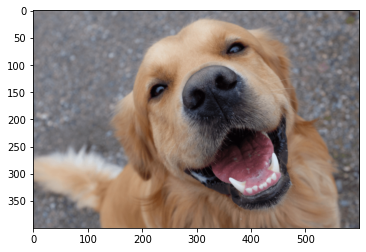

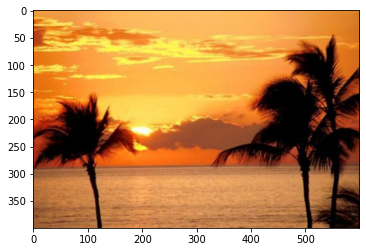

In [ ]:
# Mostra as imagens
plt.figure()
plt.imshow(im_convert(content))
plt.figure()
plt.imshow(im_convert(style))

## Camadas VGG19

Para obter as representações de conteúdo e estilo de uma imagem, precisamos passar uma imagem adiante pela rede VGG19 até chegar à(s) camada(s) desejada(s) e depois obter a saída dessa camada.

In [ ]:
# Imprime a estrutura VGG19 para poder ver os nomes de várias camadas
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Recursos de conteúdo e estilo

Abaixo, função para mapeamento dos nomes das camadas para os nomes encontrados no "paper" para a _representação do conteúdo_ e a _representação de estilo_.

In [ ]:
def get_features(image, model, layers=None):
    """ Executa uma imagem adiante através de um modelo e obtenha os recursos para um conjunto de camadas.
    Camadas padrão são para correspondência VGGNet Gatys et al (2016)
    """

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

## Matriz Gram

A saída de cada camada convolucional é um tensor com dimensões associadas ao `batch_size`, uma profundidade, `d` e alguma altura e largura (`h`,`w`). A matriz Gram de uma camada convolucional pode ser calculada da seguinte forma:
* Obtenha a profundidade, altura e largura de um tensor usando `batch_size, d, h, w = tensor.size`
* Remodelar esse tensor para que as dimensões espaciais sejam achatadas
* Calcule a matriz grama multiplicando o tensor remodelado pela sua transposição

In [ ]:
def gram_matrix(tensor):
    """ Calcular a matriz de Gram de um dado tensor
    Matriz de Gram: https://en.wikipedia.org/wiki/Gramian_matrix
    """

    _, d, h, w = tensor.size()

    tensor = tensor.view(d, h * w)

    gram = torch.mm(tensor, tensor.t())

    return gram

## Juntando tudo

Agora que escrevemos funções para extrair recursos e calcular a matriz Gram de uma determinada camada convolucional; vamos juntar todas essas peças! Extrairemos nossos recursos de nossas imagens e calcularemos as matrizes de grama para cada camada em nossa representação de estilo.

In [ ]:
# Obtenha recursos de conteúdo e estilo apenas uma vez antes do treinamento
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calcular as matrizes de Gram para cada camada de nossa representação de estilo
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Criar uma terceira imagem "alvo" e prepará-la para alterações
# é uma boa ideia começar com o destino como uma cópia da nossa imagem *content*
# e iterativamente mudar seu estilo
target = content.clone().requires_grad_(True).to(device)

## Perdas e pesos

#### Pesos de estilos de camadas individuais

Abaixo, você tem a opção de ponderar a representação do estilo em cada camada relevante. Sugerimos que você use um intervalo entre 0 e 1 para ponderar essas camadas. Ao ponderar as camadas anteriores (`conv1_1` e` conv2_1`) mais, é possível obter artefatos mais do estilo na imagem de destino resultante. Se você optar por ponderar as camadas posteriores, terá mais ênfase em recursos menores. Isso ocorre porque cada camada tem um tamanho diferente e, juntos, eles criam uma representação de estilo em várias escalas!

#### Peso do conteúdo e estilo

Assim como no artigo, definimos um alfa (`content_weight`) e um beta (`style_weight`). Essa proporção afetará o quão estilizada é sua imagem final. É recomendável deixar o content_weight = 1 e definir o style_weight para atingir a proporção desejada.

In [ ]:
# Pesos para cada camada de estilo
# Ponderar mais camadas anteriores resultará em artefatos de estilo *maiores*
# Observe que estamos excluindo 'conv4_2' nossa representação de conteúdo
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# Você pode optar por deixá-los como estão
content_weight = 1  # alpha
style_weight = 1e6  # beta

## Atualizando a meta e calculando perdas

Você decidirá sobre várias etapas para atualizar sua imagem; isso é semelhante ao ciclo de treinamento que você já viu antes, apenas estamos alterando nossa imagem _target_ e nada mais sobre o VGG19 ou qualquer outra imagem. Portanto, você decide realmente o número de etapas! **Recomendo usar pelo menos 2000 etapas para obter bons resultados.** Mas você pode começar com menos etapas se estiver apenas testando diferentes valores de peso ou experimentando imagens diferentes.

Dentro do loop de iteração, você calculará as perdas de conteúdo e estilo e atualizará sua imagem de destino, de acordo.

#### Perda de conteúdo

A perda de conteúdo será a diferença quadrática média entre os recursos de destino e conteúdo na camada `conv4_2`. Isso pode ser calculado da seguinte maneira:
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Perda de estilo

A perda de estilo é calculada de maneira semelhante, apenas você precisa percorrer um número de camadas, especificadas pelo nome no nosso dicionário `style_weights`.
> Você calculará a matriz de Gram para a imagem de destino, `target_gram` e a imagem de estilo` style_gram` em cada uma dessas camadas e comparará essas matrizes de grama, calculando a `layer_style_loss`.
> Mais tarde, você verá que esse valor é normalizado pelo tamanho da camada.

#### Perda total

Por fim, você criará a perda total adicionando as perdas de estilo e conteúdo e ponderando-as com o alfa e o beta especificados!

Intermitentemente, imprimiremos essa perda; não se assuste se a perda for muito grande. Leva algum tempo para que o estilo de uma imagem mude e você deve se concentrar na aparência da imagem de destino e não em qualquer valor de perda. Ainda assim, você deve ver que essa perda diminui com o número de iterações.

Total loss:  58524172.0


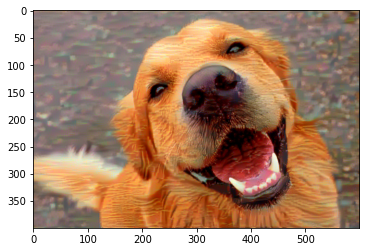

Total loss:  7826100.5


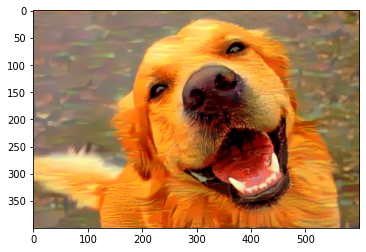

Total loss:  3388968.25


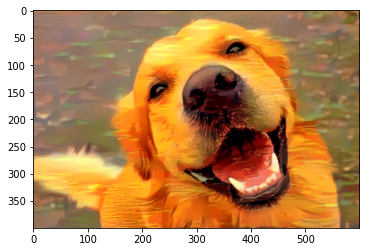

Total loss:  2233026.75


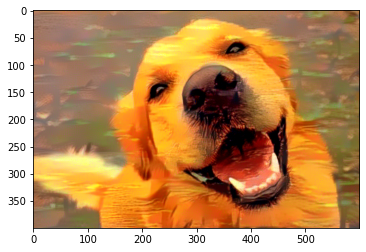

Total loss:  1663405.875


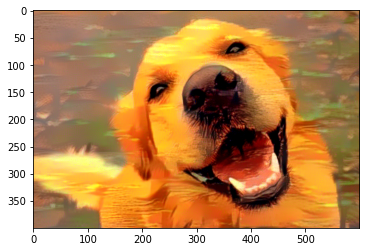

Total loss:  1299333.75


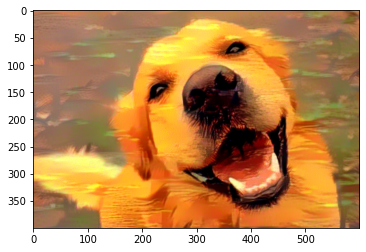

Total loss:  1043694.125


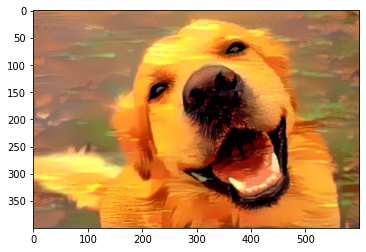

Total loss:  851940.0625


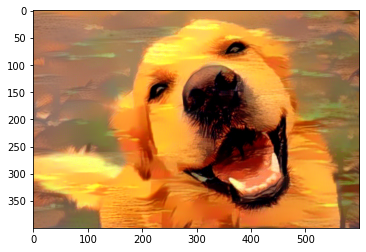

Total loss:  702370.4375


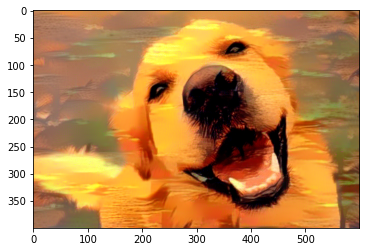

Total loss:  582709.75


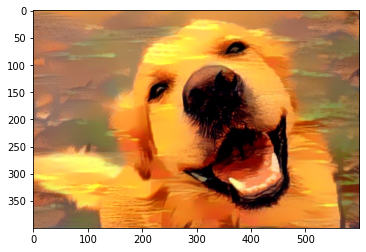

Total loss:  483876.90625


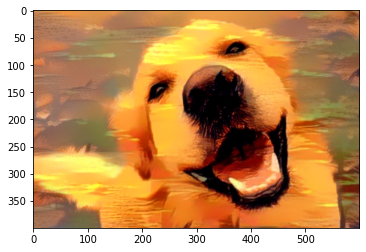

Total loss:  401465.5625


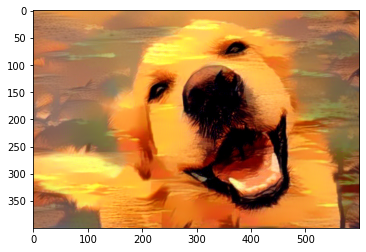

In [ ]:
# Para exibir a imagem de destino, de forma intermitente
show_every = 400

# hyperparâmetros
optimizer = optim.Adam([target], lr=0.003)
steps = 5000  # Decida quantas iterações

for ii in range(1, steps+1):

    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0

    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)


    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Mostra o resultado

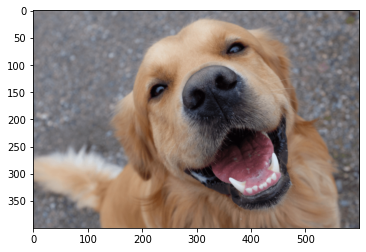

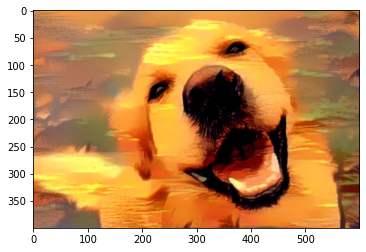

In [ ]:
# Mostra a imagem de conteudo e o resultado
plt.figure()
plt.imshow(im_convert(content))
plt.figure()
plt.imshow(im_convert(target))

In [ ]:
# Exportar para imagem .jpg
matplotlib.image.imsave('/content/result.jpg',im_convert(target))